## MODELO DE JUEGO A PARTIR DE EVENTOS Y MAPAS DE CALOR DE ESTOS

**Objetivos:**

    

**Datos:**
Inicialmente se pensaba utilizar los datos del mundial por ser una de las pocas competiciones con datos de todos los partidos (64 en este caso). Sin embargo, la semana pasada Statsbomb liberó los eventos de todos los partidos de LaLiga 2015/2016 (380 partidos). Esto fue de gran ayuda puesto que ahora tenemos 20 partidos por equipo y no menos de 10 como con los datos del mundial; lo cual permite identificar mejor el modelo de juego de un equipo.

## 0. PRE REQUERIMIENTOS

In [ ]:
!pip install mplsoccer
!pip install scikit-learn
!pip install statsbombpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from statsbombpy import sb
from itertools import chain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. LECTURA DE DATOS

In [ ]:
#Dataframe partidos de LaLiga temporada 2015/2016
df = sb.matches(competition_id=11, season_id=27)
df.tail(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
377,266490,2015-09-20,20:30:00.000,Spain - La Liga,2015/2016,Barcelona,Levante UD,4,1,available,...,2021-06-13T16:17:31.694,4,Regular Season,Spotify Camp Nou,David Fernández Borbalan,Luis Enrique Martínez García,Luis Lucas Alcaraz González,1.1.0,2,2
378,266254,2016-02-14,21:30:00.000,Spain - La Liga,2015/2016,Barcelona,Celta Vigo,6,1,available,...,2021-06-13T16:17:31.694,24,Regular Season,Spotify Camp Nou,NaN,Luis Enrique Martínez García,Manuel Eduardo Berizzo,1.1.0,2,2
379,266557,2016-04-17,20:30:00.000,Spain - La Liga,2015/2016,Barcelona,Valencia,1,2,available,...,2021-06-13T16:17:31.694,33,Regular Season,Spotify Camp Nou,David Fernández Borbalan,Luis Enrique Martínez García,Francisco Martín Ayestarán Barandiarán,1.1.0,2,2


In [ ]:
#Lista de partidos de LaLiga 2015/2016
matches = list(df.match_id)
len(matches)

380

In [ ]:
#UNION DE TODOS LOS DATOS DE EVENTOS DE LA LIGA TEMPORADA 2015/2016
df_events = pd.concat([sb.events(match) for match in matches])

## 2. EXPLORACIÓN DE DATOS

In [ ]:
print(list(df_events.columns))

['bad_behaviour_card', 'ball_receipt_outcome', 'ball_recovery_recovery_failure', 'block_deflection', 'carry_end_location', 'clearance_aerial_won', 'clearance_body_part', 'clearance_head', 'clearance_left_foot', 'clearance_right_foot', 'counterpress', 'dribble_no_touch', 'dribble_nutmeg', 'dribble_outcome', 'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage', 'foul_committed_card', 'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id', 'index', 'interception_outcome', 'location', 'match_id', 'minute', 'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_deflected', 'pass_end_location', 'pass_goal_assist', 'pass_height', 'pass_inswinging', 'pass_length', 'pass_miscommunication', 'pass_no_touch', 'pass_outcome', 'p

In [ ]:
df_events[['team', 'timestamp', 'type','player', 'location','pass_type', 'pass_angle','shot_type',
           'duel_type', 'duration']]

,team,timestamp,type,player,location,pass_type,pass_angle,shot_type,duel_type,duration
0,Eibar,00:00:00.500,Pass,Adrián González Morales,"[61.0, 40.1]",Kick Off,1.419191,NaN,NaN,0.486053
1,Eibar,00:00:00.986,Pass,Borja González Tomás,"[61.2, 41.3]",NaN,-2.137526,NaN,NaN,1.397421
2,Eibar,00:00:04.078,Pass,Daniel García Carrillo,"[49.2, 33.5]",NaN,2.167094,NaN,NaN,1.558912
3,Eibar,00:00:07.214,Pass,Aleksandar Pantić,"[32.3, 58.4]",NaN,-1.630554,NaN,NaN,1.633776
4,Eibar,00:00:13.855,Pass,Mauro Javier Dos Santos,"[40.5, 76.1]",NaN,-1.658705,NaN,NaN,2.934427
...,...,...,...,...,...,...,...,...,...,...
1286186,Barcelona,00:26:49.777,50/50,Javier Alejandro Mascherano,"[36.5, 23.7]",NaN,NaN,NaN,NaN,0.000000
1286187,Valencia,00:26:49.777,50/50,André Filipe Tavares Gomes,"[83.6, 56.4]",NaN,NaN,NaN,NaN,0.000000
1286188,Barcelona,00:25:17.444,Own Goal Against,Ivan Rakitić,"[1.4, 50.6]",NaN,NaN,NaN,NaN,0.000000
1286189,Valencia,00:25:17.444,Own Goal For,Guilherme Magdalena Siqueira,"[118.7, 29.5]",NaN,NaN,NaN,NaN,0.000000


In [ ]:
#¿Qué información obtengo?
filter_col = ['bad_behaviour_card', 'ball_receipt_outcome', 'ball_recovery_recovery_failure', 'block_deflection',
           'block_offensive', 'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
           'clearance_left_foot', 'clearance_right_foot', 'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'duel_outcome',
           'duel_type', 'duration', 'foul_committed_advantage', 'foul_committed_card', 'foul_committed_type',
           'foul_won_advantage', 'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
           'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type',
           'injury_stoppage_in_chain', 'interception_outcome', 'off_camera', 'out',
           'pass_aerial_won', 'pass_body_part', 'pass_cross', 'pass_cut_back',
           'pass_deflected', 'pass_goal_assist', 'pass_height', 'pass_miscommunication',
           'pass_outcome', 'pass_outswinging', 'pass_shot_assist', 'pass_switch', 'pass_technique',
           'pass_through_ball', 'pass_type', 'period', 'play_pattern', 'position',
           'possession_team', 'possession_team_id', 'related_events', 'shot_aerial_won', 'shot_body_part',
           'shot_deflected', 'shot_end_location', 'shot_first_time', 'shot_freeze_frame',
           'shot_one_on_one', 'shot_open_goal', 'shot_outcome', 'shot_statsbomb_xg', 'shot_technique', 'shot_type',
           'substitution_outcome', 'team', 'team_id', 'type',
           'under_pressure']

for i in range(len(filter_col)):
    print(f'{i} {filter_col[i]}: ')
    try:
        print(df_events[filter_col[i]].unique())
    except:
        print('Info. no disponible')

0 bad_behaviour_card: 
[nan 'Yellow Card' 'Red Card' 'Second Yellow']
1 ball_receipt_outcome: 
[nan 'Incomplete']
2 ball_recovery_recovery_failure: 
[nan True]
3 block_deflection: 
[nan True]
4 block_offensive: 
[nan True]
5 clearance_aerial_won: 
[nan True]
6 clearance_body_part: 
[nan 'Left Foot' 'Right Foot' 'Head' 'Other']
7 clearance_head: 
[nan True]
8 clearance_left_foot: 
[nan True]
9 clearance_right_foot: 
[nan True]
10 counterpress: 
[nan True]
11 dribble_nutmeg: 
[nan True]
12 dribble_outcome: 
[nan 'Complete' 'Incomplete']
13 duel_outcome: 
[nan 'Success In Play' 'Lost Out' 'Won' 'Lost In Play' 'Success Out']
14 duel_type: 
[nan 'Aerial Lost' 'Tackle']
15 duration: 
[ 0.        0.486053  1.397421 ...  0.935998  0.70113  60.      ]
16 foul_committed_advantage: 
[nan True]
17 foul_committed_card: 
[nan 'Yellow Card' 'Second Yellow' 'Red Card']
18 foul_committed_type: 
[nan 'Handball' 'Dangerous Play' 'Dive' 'Foul Out' 'Backpass Pick'
 '6 Seconds']
19 foul_won_advantage: 
[nan

In [ ]:
#df_prueba = df_events[df_events.match_id==3825617]
#df_ordenado = df_prueba.sort_values('timestamp')
#df_ordenado[['match_id','team','player','type','pass_type','location','timestamp', 'play_pattern']].tail(10)

In [ ]:
df_events[df_events.type=='Pass'][['team','player','pass_type','location','pass_outcome', 'play_pattern']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365288 entries, 0 to 1283562
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   team          365288 non-null  object
 1   player        365288 non-null  object
 2   pass_type     83669 non-null   object
 3   location      365288 non-null  object
 4   pass_outcome  88525 non-null   object
 5   play_pattern  365288 non-null  object
dtypes: object(6)
memory usage: 19.5+ MB


In [ ]:
df_events.type.unique()

array(['Pass', 'Ball Receipt*', 'Carry', 'Pressure', 'Miscontrol', 'Duel',
       'Interception', 'Goal Keeper', 'Clearance', 'Ball Recovery',
       'Shot', 'Foul Committed', 'Foul Won', 'Dribbled Past', 'Dribble',
       'Block', 'Dispossessed', 'Shield', '50/50', 'Offside',
       'Referee Ball-Drop', 'Error', 'Own Goal For', 'Own Goal Against',
       'Bad Behaviour'], dtype=object)

In [ ]:
tipo_eventos = df_events.type.unique()
n_event_xtipo = []
for event in tipo_eventos:
  n_eventos = len(df_events[df_events.type==event])
  n_event_xtipo.append(n_eventos)

In [ ]:
varx = tipo_eventos[:17]
vary = n_event_xtipo[:17]

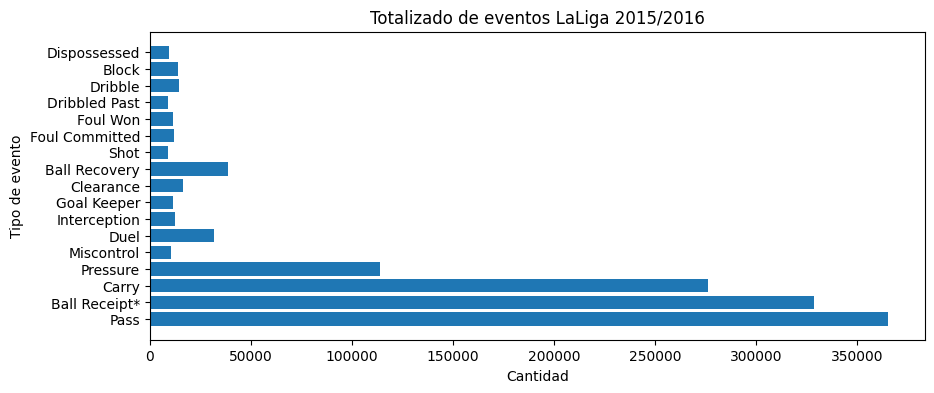

In [ ]:
plt.figure(figsize=(10,4))
plt.barh(varx, vary)
plt.xlabel('Cantidad')
plt.ylabel('Tipo de evento')
plt.title ('Totalizado de eventos LaLiga 2015/2016',fontsize = 12)
plt.show()

## LIMPIEZA DE DATOS

In [ ]:
df_events = df_events[~df_events.location.isnull()] #requerimos eventos con localización de la acción
df_events = df_events.reset_index(drop=True)

In [ ]:
#creando 2 nuevas columnas con las posiciones x e y a partir de la columna posición
df_events[['x', 'y']] = df_events['location'].apply(lambda x: pd.Series([x[0], x[1]]))

In [ ]:
df_events[['type','x', 'y']].head(5)

,type,x,y
0,Pass,61.0,40.1
1,Pass,61.2,41.3
2,Pass,49.2,33.5
3,Pass,32.3,58.4
4,Pass,40.5,76.1


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#ruta_archivo = '/content/drive/MyDrive/SDC - IA aplicada al deñorte/PFM/events_LaLiga_2015-2016.csv'
#df_events.to_csv(ruta_archivo, index=False)

In [ ]:
#DATASET AÑADIENDO LAS POSICIONES FINALES DE LAS ACCIONES
mask_type = (df_events.type== 'Pass')
df_temp2 = df_events[mask_type]
import ast
#creando 2 nuevas columnas con las posiciones finales de los eventos
def extract_values(row):
      row_new = ast.literal_eval(row['pass_end_location']) #convertir de str a list
      return row_new[0], row_new[1]
# Aplicar la función a la columna 'location' y crear las nuevas columnas
df_temp2[['x_end', 'y_end']] = df_temp2.apply(lambda row: pd.Series(extract_values(row)), axis=1)

In [ ]:
#ruta_archivo2 = '/content/drive/MyDrive/SDC - IA aplicada al deñorte/PFM/events_LaLiga_2015-2016_pass_end.csv'
#df_temp2.to_csv(ruta_archivo2, index=False)

##OBTENIENDO EVENTOS DE INTERES

In [ ]:
ruta_archivo = '/content/drive/MyDrive/SDC - IA aplicada al deñorte/PFM/events_LaLiga_2015-2016.csv'
df_events = pd.read_csv(ruta_archivo)
#columnas_borrar = ['x_end', 'y_end']
#df_events = df_events.drop(columnas_borrar, axis=1)

<ipython-input-6-4aa27e8d20c5>:2: DtypeWarning: Columns (0,1,2,3,4,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,30,34,35,37,39,40,41,42,43,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59,70,71,72,73,74,75,76,77,79,80,89,90,91,93,94,95,96,97,98,99,100,101,103,104,105,106,107,108,109,110,111,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df_events = pd.read_csv(ruta_archivo)


In [ ]:

df_events[df_events.type==:].value_counts()

SyntaxError: ignored

In [ ]:
ruta_archivo2 = '/content/drive/MyDrive/SDC - IA aplicada al deñorte/PFM/events_LaLiga_2015-2016_pass_end.csv'
df_temp2 = pd.read_csv(ruta_archivo2)

In [ ]:
df_temp2[['type','pass_type','pass_end_location','x_end', 'y_end']].tail(5)

,type,pass_type,pass_end_location,x_end,y_end
365283,Pass,NaN,"[82.6, 38.8]",82.6,38.8
365284,Pass,NaN,"[119.9, 53.5]",119.9,53.5
365285,Pass,Goal Kick,"[66.8, 35.2]",66.8,35.2
365286,Pass,Recovery,"[51.4, 33.0]",51.4,33.0
365287,Pass,NaN,"[59.4, 36.4]",59.4,36.4


In [ ]:
teams = df_events.team.unique()
teams

array(['Eibar', 'Levante UD', 'Sevilla', 'Las Palmas', 'Getafe',
       'RC Deportivo La Coruña', 'Málaga', 'Espanyol', 'Sporting Gijón',
       'Villarreal', 'Rayo Vallecano', 'Real Betis', 'Real Madrid',
       'Athletic Club', 'Atlético Madrid', 'Celta Vigo', 'Real Sociedad',
       'Valencia', 'Granada', 'Barcelona'], dtype=object)

In [ ]:
def metric_total_train_test(df, metric_type, filtro=True, ubicacion='start'):
  '''
  Funcion que obtiene las posiones x,y donde se produce una determinada accion.
  La salida de esta funcion es un arrary que contiene 625 array con 20 elementos
  cada uno. Esto representa los 625 valores (heatmap de 25x25) de los 20 equipos
  para esta métrica
  '''
  perc_train = 0.5
  total_events = []
  n_events_train = []
  n_events_test = []
  n_events = []
  total_events_train = []
  total_events_test = []

  if ubicacion=='start':
    x, y = 'x','y'
  if ubicacion =='end':
    x, y = 'x_end','y_end'

  for i in range(len(teams)):
      #eventos correspondientes a esta metrica
      mask_team = (df.team==teams[i])
      mask_type = (df.type== metric_type) & filtro
      df_temp = df[mask_team&mask_type]
      xx = df_temp[x]
      yy = df_temp[y]
      #para verificar precisión con MRR
      nn = len(xx)
      n_grupo1 = int(nn*perc_train)
      x_train = xx[:n_grupo1]
      x_test = xx[n_grupo1:]
      y_train = yy[:n_grupo1]
      y_test = yy[n_grupo1:]
      #numero de eventos
      n_events.append(nn)
      nn_train = len(x_train)
      n_events_train.append(nn_train)
      nn_test = len(x_test)
      n_events_test.append(nn_test)
      #convirtiendo a vector de heatmap - TOTAL
      pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
      bin_statistic = pitch.bin_statistic(xx, yy, statistic='count', bins=(25, 25))
      heatmap_values = bin_statistic['statistic']
      heatmap_values = np.array(heatmap_values)/38
      heatmap_values = gaussian_filter(heatmap_values, 1)
      #convirtiendo a vector de heatmap - TRAIN
      pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
      bin_statistic_train = pitch.bin_statistic(x_train, y_train, statistic='count', bins=(25, 25))
      heatmap_values_train = bin_statistic_train['statistic']
      heatmap_values_train = np.array(heatmap_values_train)/(38*perc_train)
      heatmap_values_train = gaussian_filter(heatmap_values_train, 1)
      #convirtiendo a vector de heatmap - TEST
      pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
      bin_statistic_test = pitch.bin_statistic(x_test, y_test, statistic='count', bins=(25, 25))
      heatmap_values_test = bin_statistic_test['statistic']
      heatmap_values_test = np.array(heatmap_values_test)/(38*(1-perc_train))
      heatmap_values_test = gaussian_filter(heatmap_values_test, 1)
      #---------- convertir y unir
      heatmap_values = heatmap_values.reshape(625,1)
      total_events.append(heatmap_values)
      #train y test
      heatmap_values_train = heatmap_values_train.reshape(625,1)
      total_events_train.append(heatmap_values_train)
      heatmap_values_test = heatmap_values_test.reshape(625,1)
      total_events_test.append(heatmap_values_test)

  total_events = np.hstack(total_events)
  total_events_train = np.hstack(total_events_train)
  total_events_test = np.hstack(total_events_test)

  return total_events, total_events_train, total_events_test, np.array(n_events_train), np.array(n_events_test)

### MÉTRICAS EN POSESIÓN DE BALÓN

In [ ]:
#DISPAROS
total_shots, total_shots_train, total_shots_test, n_shots_train, n_shots_test = metric_total_train_test(df_events, 'Shot')
#DRIBBLE
total_dribble, total_dribble_train, total_dribble_test, n_dribble_train, n_dribble_test = metric_total_train_test(df_events, 'Dribble')
#ASISTENCIA DE TIRO (openplay)
total_ass_shot, total_astshot_train, total_astshot_test, n_astshot_train, n_astshot_test = metric_total_train_test(df_events, 'Pass', (df_events.pass_shot_assist==True)&(df_events.pass_type!='Throw-in')&(df_events.pass_type!='Corner')&(df_events.pass_type!='Free Kick'))
#CENTROS(openplay)
total_cross, total_cross_train, total_cross_test, n_cross_train, n_cross_test = metric_total_train_test(df_events, 'Pass', (df_events.pass_cross==True)&(df_events.pass_type!='Throw-in')&(df_events.pass_type!='Corner')&(df_events.pass_type!='Free Kick'))
#PASE HACIA ULTIMA ZONA DEL CAMPO
total_toendzone, total_toendzone_train, total_toendzone_test, n_toendzone_train, n_toendzone_test = metric_total_train_test(df_temp2, 'Pass', (df_temp2.x_end>=100)&(df_temp2.pass_type!='Throw-in')&(df_temp2.pass_type!='Corner')&(df_temp2.pass_type!='Free Kick'), 'end')
#SAQUES DE META (hacia donde se lanzan)
total_goalkick, total_goalkick_train, total_goalkick_test, n_goalkick_train, n_goalkick_test = metric_total_train_test(df_temp2, 'Pass', (df_temp2.pass_type=='Goal Kick'), 'end')
#PASES PERDIDOS EN PROPIO CAMPO (openplay)
total_passlost, total_passlost_train, total_passlost_test, n_passlost_train, n_passlost_test = metric_total_train_test(df_events, 'Pass', (df_events.pass_outcome=='Incomplete')&(df_events.x<=60)&(df_events.pass_type!='Throw-in')&(df_events.pass_type!='Free Kick'))
#pases aereos
total_passaereo, total_passaereo_train, total_passaereo_test, n_passaereo_train, n_passaereo_test = metric_total_train_test(df_events, 'Pass', (df_events.pass_height=='High Pass')&(df_events.pass_type!='Throw-in')&(df_events.pass_type!='Free Kick')&(df_events.pass_type!='Corner'))
#Corneres (hacia donde se lanzan)
total_corner, total_corner_train, total_corner_test, n_corner_train, n_corner_test = metric_total_train_test(df_temp2, 'Pass', (df_temp2.pass_type=='Corner'), 'end')


### MÉTRICAS SIN BALÓN

In [ ]:
#RECUPERACIONES
total_recupera, total_recupera_train, total_recupera_test, n_recupera_train, n_recupera_test= metric_total_train_test(df_events, 'Ball Recovery', df_events.position!='Goalkeeper')
#PRESION
total_presion, total_presion_train, total_presion_test, n_presion_train, n_presion_test= metric_total_train_test(df_events,'Pressure')
#FALTAS COMETIDAS
total_faltas, total_faltas_train, total_faltas_test, n_faltas_train, n_faltas_test = metric_total_train_test(df_events, 'Foul Committed')
#DRIBBLE RECIBIDO
total_dribblerecib, total_dribblerecib_train, total_dribblerecib_test, n_dribblerecib_train, n_dribblerecib_test = metric_total_train_test(df_events, 'Dribbled Past')


## SUPRESIÓN DE FUERZA DEL EQUIPO

In [ ]:
# FUNCION SUPRESION DE FUERZA
def supresion_fuerza(array_event, ratio_event):
  '''
  array_evento debe tener una dimension de (625,20)
  n_event es el numero de
  '''
  event_frelativa = np.empty((0, 20))
  for k in range(array_event.shape[0]):
    vector = array_event[k]*ratio_event
    event_frelativa = np.vstack((event_frelativa, vector))
  return event_frelativa

In [ ]:
#EVENTOS CON BALON
#ratios
nevents_inpos_train = n_shots_train+n_dribble_train+n_astshot_train+n_cross_train+n_toendzone_train+n_goalkick_train+n_passlost_train+n_passaereo_train+n_corner_train
nevents_inpos_test = n_shots_test+n_dribble_test+n_astshot_test+n_cross_test+n_toendzone_train+n_goalkick_test+n_passlost_test+n_passaereo_test+n_corner_test

ratio_shots_train = n_shots_train/ nevents_inpos_train
ratio_shots_test = n_shots_train/ nevents_inpos_test
ratio_dribble_train = n_dribble_train/ nevents_inpos_train
ratio_dribble_test = n_dribble_test/ nevents_inpos_test
ratio_astshot_train = n_astshot_train/ nevents_inpos_train
ratio_astshot_test = n_astshot_test/ nevents_inpos_test
ratio_cross_train = n_cross_train/nevents_inpos_train
ratio_cross_test = n_cross_test/nevents_inpos_test
ratio_toendzone_train = n_toendzone_train/nevents_inpos_train
ratio_toendzone_test = n_toendzone_test/nevents_inpos_test
ratio_goalkick_train = n_goalkick_train/nevents_inpos_train
ratio_goalkick_test = n_goalkick_test/nevents_inpos_test
ratio_passlost_train = n_passlost_train/nevents_inpos_train
ratio_passlost_test = n_passlost_test/nevents_inpos_test
ratio_passaereo_train = n_passaereo_train/nevents_inpos_train
ratio_passaereo_test = n_passaereo_test/nevents_inpos_test
ratio_corner_train = n_corner_train/nevents_inpos_train
ratio_corner_test = n_corner_test/nevents_inpos_test

# Aplicando supresión de fuerza
total_shots_train = supresion_fuerza(total_shots_train, ratio_shots_train)
total_shots_test = supresion_fuerza(total_shots_test, ratio_shots_test)
total_dribble_train = supresion_fuerza(total_dribble_train, ratio_dribble_train)
total_dribble_test = supresion_fuerza(total_dribble_test, ratio_dribble_test)
total_astshot_train = supresion_fuerza(total_astshot_train, ratio_astshot_train)
total_astshot_test = supresion_fuerza(total_astshot_test, ratio_astshot_test)
total_cross_train = supresion_fuerza(total_cross_train, ratio_cross_train)
total_cross_test = supresion_fuerza(total_cross_test, ratio_cross_test)
total_toendzone_train = supresion_fuerza(total_toendzone_train, ratio_toendzone_train)
total_toendzone_test = supresion_fuerza(total_toendzone_test, ratio_toendzone_test)
total_goalkick_train = supresion_fuerza(total_goalkick_train, ratio_goalkick_train)
total_goalkick_test = supresion_fuerza(total_goalkick_test, ratio_goalkick_test)
total_passlost_train = supresion_fuerza(total_passlost_train, ratio_passlost_train)
total_passlost_test = supresion_fuerza(total_passlost_test, ratio_passlost_test)
total_passaereo_train = supresion_fuerza(total_passaereo_train, ratio_passaereo_train)
total_passaereo_test = supresion_fuerza(total_passaereo_test, ratio_passaereo_test)
total_corner_train = supresion_fuerza(total_corner_train, ratio_corner_train)
total_corner_test = supresion_fuerza(total_corner_test, ratio_corner_test)

In [ ]:
print(ratio_shots_train.mean(), ratio_dribble_train.mean(), ratio_astshot_train.mean(), ratio_cross_train.mean(),
      ratio_toendzone_train.mean(), ratio_goalkick_train.mean(), ratio_passlost_train.mean())

0.07752356884154557 0.12386131115285197 0.04084564734704519 0.07421200479290688 0.330838145483887 0.05259678651640608 0.3001225358653573


In [ ]:
#EVENTOS SIN BALON
#ratios
nevents_inposrival = []
for equipo in teams:
  match_equipo = df_events[df_events.team==equipo].match_id.unique()
  df_equipo = df_events[df_events.match_id.isin(match_equipo)]
  df_noEquipo = df_equipo[df_equipo.team!=equipo][['team','type']]
  n_inrival = len(df_noEquipo[df_noEquipo.type.isin(['Pass', 'Shot', 'Dribble'])])
  nevents_inposrival.append(n_inrival)
nevents_inposrival = np.array(nevents_inposrival)*0.6

'''
nevents_outpos_train = n_recupera_train + n_presion_train + n_faltas_train + n_dribblerecib_train
nevents_outpos_test = n_recupera_test + n_presion_test + n_faltas_test + n_dribblerecib_test

ratio_recupera_train = n_recupera_train/nevents_outpos_train
ratio_recupera_test = n_recupera_test/nevents_outpos_test
ratio_presion_train = n_presion_train/nevents_outpos_train
ratio_presion_test = n_presion_test/nevents_outpos_test
ratio_faltas_train = n_faltas_train/nevents_outpos_train
ratio_faltas_test = n_faltas_test/nevents_outpos_test
ratio_dribblerecib_train = n_dribblerecib_train/nevents_outpos_train
ratio_dribblerecib_test = n_dribblerecib_test/nevents_outpos_test
'''

'\nnevents_outpos_train = n_recupera_train + n_presion_train + n_faltas_train + n_dribblerecib_train\nnevents_outpos_test = n_recupera_test + n_presion_test + n_faltas_test + n_dribblerecib_test\n\nratio_recupera_train = n_recupera_train/nevents_outpos_train\nratio_recupera_test = n_recupera_test/nevents_outpos_test\nratio_presion_train = n_presion_train/nevents_outpos_train\nratio_presion_test = n_presion_test/nevents_outpos_test\nratio_faltas_train = n_faltas_train/nevents_outpos_train\nratio_faltas_test = n_faltas_test/nevents_outpos_test\nratio_dribblerecib_train = n_dribblerecib_train/nevents_outpos_train\nratio_dribblerecib_test = n_dribblerecib_test/nevents_outpos_test\n'

In [ ]:
ratio_recupera_train = n_recupera_train/(nevents_inposrival*0.5)
ratio_recupera_test = n_recupera_test/(nevents_inposrival*0.5)
ratio_presion_train = n_presion_train/(nevents_inposrival*0.5)
ratio_presion_test = n_presion_test/(nevents_inposrival*0.5)
ratio_faltas_train = n_faltas_train/(nevents_inposrival*0.5)
ratio_faltas_test = n_faltas_test/(nevents_inposrival*0.5)
ratio_dribblerecib_train = n_dribblerecib_train/(nevents_inposrival*0.5)
ratio_dribblerecib_test = n_dribblerecib_test/(nevents_inposrival*0.5)

# Aplicando supresión de fuerza
total_recupera_train = supresion_fuerza(total_recupera_train, ratio_recupera_train)
total_recupera_test = supresion_fuerza(total_recupera_test, ratio_recupera_test)
total_presion_train = supresion_fuerza(total_presion_train, ratio_presion_train)
total_presion_test = supresion_fuerza(total_presion_test, ratio_presion_test)
total_faltas_train = supresion_fuerza(total_faltas_train, ratio_faltas_train)
total_faltas_test = supresion_fuerza(total_faltas_test, ratio_faltas_test)
total_dribblerecib_train = supresion_fuerza(total_dribblerecib_train, ratio_dribblerecib_train)
total_dribblerecib_test = supresion_fuerza(total_dribblerecib_test, ratio_dribblerecib_test)

## COMPROBANDO SI LA DIVISIÓN DE DATASET FUE BALANCEADA

In [ ]:
dif_div_shots = np.mean(np.abs(ratio_shots_train-ratio_shots_test))*100
print(f'La diferencia entre los porcentajes que ocupan los TIROS en ambos grupos de eventos es de {dif_div_shots}%')
dif_div_dribble = np.mean(np.abs(ratio_dribble_train-ratio_dribble_test))*100
print(f'La diferencia entre los porcentajes que ocupan los DRIBBLEs en ambos grupos de eventos es de {dif_div_dribble}%')
dif_div_astshot = np.mean(np.abs(ratio_astshot_train-ratio_astshot_test))*100
print(f'La diferencia entre los porcentajes que ocupan las ASIS. DE TIRO en ambos grupos de eventos es de {dif_div_astshot}%')
dif_div_cross = np.mean(np.abs(ratio_cross_train-ratio_cross_test))*100
print(f'La diferencia entre los porcentajes que ocupan los CENTROS en ambos grupos de eventos es de {dif_div_cross}%')
dif_div_toendzone = np.mean(np.abs(ratio_toendzone_train-ratio_toendzone_test))*100
print(f'La diferencia entre los porcentajes que ocupan los PASES HACIA ULTIMO 5TO en ambos grupos de eventos es de {dif_div_toendzone}%')
dif_div_goalkick = np.mean(np.abs(ratio_goalkick_train-ratio_goalkick_test))*100
print(f'La diferencia entre los porcentajes que ocupan los SAQUES DE META en ambos grupos de eventos es de {dif_div_goalkick}%')
dif_div_passlost = np.mean(np.abs(ratio_passlost_train-ratio_passlost_test))*100
print(f'La diferencia entre los porcentajes que ocupan los PASES FALLADOS EN CAMPO PROPIO en ambos grupos de eventos es de {dif_div_passlost}%')

La diferencia entre los porcentajes que ocupan los TIROS en ambos grupos de eventos es de 0.007915111887786194%
La diferencia entre los porcentajes que ocupan los DRIBBLEs en ambos grupos de eventos es de 0.013445287760313547%
La diferencia entre los porcentajes que ocupan las ASIS. DE TIRO en ambos grupos de eventos es de 0.017359324663682937%
La diferencia entre los porcentajes que ocupan los CENTROS en ambos grupos de eventos es de 0.01888556234728573%
La diferencia entre los porcentajes que ocupan los PASES HACIA ULTIMO 5TO en ambos grupos de eventos es de 0.02610113672751963%
La diferencia entre los porcentajes que ocupan los SAQUES DE META en ambos grupos de eventos es de 0.010242092374983351%
La diferencia entre los porcentajes que ocupan los PASES FALLADOS EN CAMPO PROPIO en ambos grupos de eventos es de 0.021846411721266334%


Podemos concluir que la divisón fue balanceada, ya que la diferencia es en promedio menos del 0.05% en todos los casos

## DESCOMPOSICIÓN MEDIANTE NMF

### Funciones

In [ ]:
def NMF(matriz, n_comp):

  #quitarle la parte de max val que solo sirve para graficar
    from sklearn.decomposition import non_negative_factorization
    W, H, n_iter = non_negative_factorization(matriz, n_components=n_comp, init='random', random_state=0)

    W1 = W[:,0].reshape(25,25)
    H1 = H[0]
    X1 = (W1*H1.mean())
    W2 = W[:,1].reshape(25,25)
    H2 = H[1]
    X2 = (W2*H2.mean())
    W3 = W[:,2].reshape(25,25)
    H3 = H[2]
    X3 = (W3*H3.mean())
    #artificio grafico
    max_val = max(np.amax(X1), np.amax(X2), np.amax(X3))
    X1_prima=X1
    X2_prima=X2
    X3_prima=X3
    X1_prima[0][0] = max_val
    X2_prima[0][0] = max_val
    X3_prima[0][0] = max_val
    components = [X1_prima, X2_prima, X3_prima]

    if n_comp==3:
        return [H1, H2, H3]

    if n_comp==4:
        W4 = W[:,3].reshape(25,25)
        H4 = H[3]
        X4 = (W4*H4.mean())
        max_val = max(np.amax(X1), np.amax(X2), np.amax(X3),np.amax(X4))
        X4_prima=X4
        X1_prima[0][0] = max_val
        X2_prima[0][0] = max_val
        X3_prima[0][0] = max_val
        X4_prima[0][0] = max_val
        components = [X1_prima, X2_prima, X3_prima, X4_prima]
        return [H1, H2, H3, H4]

    if n_comp==5:
        W4 = W[:,3].reshape(25,25)
        H4 = H[3]
        X4 = (W4*H4.mean())
        W5 = W[:,4].reshape(25,25)
        H5 = H[4]
        X5 = (W5*H5.mean())
        max_val = max(np.amax(X1), np.amax(X2), np.amax(X3),np.amax(X4), np.amax(X5))
        X4_prima=X4
        X5_prima=X5
        X1_prima[0][0] = max_val
        X2_prima[0][0] = max_val
        X3_prima[0][0] = max_val
        X4_prima[0][0] = max_val
        X5_prima[0][0] = max_val
        components = [X1_prima, X2_prima, X3_prima, X4_prima, X5_prima]
        return [H1, H2, H3, H4, H5]

In [ ]:

def nmf_grafico(matriz, n_comp):

    from sklearn.decomposition import non_negative_factorization
    W, H, n_iter = non_negative_factorization(matriz, n_components=n_comp, init='random', random_state=0)

    W1 = W[:,0].reshape(25,25)
    H1 = H[0]
    X1 = (W1*H1.mean())
    W2 = W[:,1].reshape(25,25)
    H2 = H[1]
    X2 = (W2*H2.mean())
    W3 = W[:,2].reshape(25,25)
    H3 = H[2]
    X3 = (W3*H3.mean())

    #artificio grafico
    max_val = max(np.amax(X1), np.amax(X2), np.amax(X3))
    X1_prima=X1
    X2_prima=X2
    X3_prima=X3
    X1_prima[0][0] = max_val
    X2_prima[0][0] = max_val
    X3_prima[0][0] = max_val
    components = [X1_prima, X2_prima, X3_prima]

    if n_comp==3:
      pass
    if n_comp==4:
        W4 = W[:,3].reshape(25,25)
        H4 = H[3]
        X4 = (W4*H4.mean())
        max_val = max(np.amax(X1), np.amax(X2), np.amax(X3),np.amax(X4))
        X4_prima=X4
        X1_prima[0][0] = max_val
        X2_prima[0][0] = max_val
        X3_prima[0][0] = max_val
        X4_prima[0][0] = max_val
        components = [X1_prima, X2_prima, X3_prima, X4_prima]

    if n_comp==5:
        W4 = W[:,3].reshape(25,25)
        H4 = H[3]
        X4 = (W4*H4.mean())
        W5 = W[:,4].reshape(25,25)
        H5 = H[4]
        X5 = (W5*H5.mean())
        max_val = max(np.amax(X1), np.amax(X2), np.amax(X3),np.amax(X4), np.amax(X5))
        X4_prima=X4
        X5_prima=X5
        X1_prima[0][0] = max_val
        X2_prima[0][0] = max_val
        X3_prima[0][0] = max_val
        X4_prima[0][0] = max_val
        X5_prima[0][0] = max_val
        components = [X1_prima, X2_prima, X3_prima, X4_prima, X5_prima]

    for i in components:
        # setup pitch
        pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
                      pitch_color='#22312b', line_color='#efefef')
        # draw
        fig, ax = pitch.draw(figsize=(4.2, 3.1))
        fig.set_facecolor('#22312b')
        bin_statistic = pitch.bin_statistic(i[0], i[1], statistic='count', bins=(25, 25))
        bin_statistic['statistic'] = i
        #bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
        pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
        # Add the colorbar and format off-white
        cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
        cbar.outline.set_edgecolor('#efefef')
        cbar.ax.yaxis.set_tick_params(color='#efefef')
        ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')


### Gráficos de ejemplo

In [ ]:
#Ejemplo visual de una descomposicon de mapa de calor mediante NMF
#La funcion "nmf_grafico" a parte de dar los valores de H (componentes), grafica los mapas de calor#

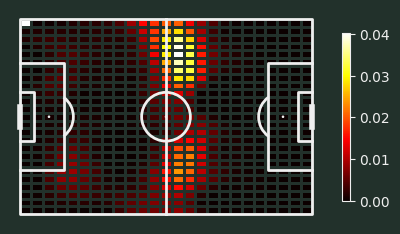

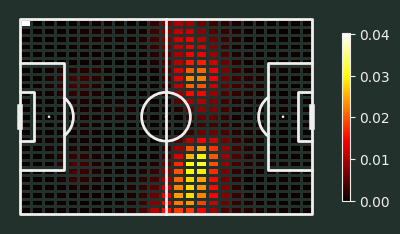

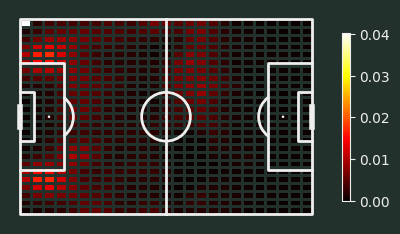

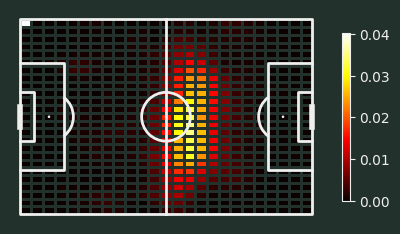

In [ ]:
nmf_grafico(total_goalkick,4)

### Obteniendo los pesos H

El número después de la flecha representa la cantidad de componentes en que se dividió cada mapa de calor de evento. Este valor se obtuvo en algunos casos siguiendo los ejemplos de la documentación y en otros casos probando descompoiciones, visualizando sus mapas de calor ya descompuestos y decidiendo en base a criterios de futbol



*   total_shots -> 4
* total_cross -> 3
*   total_dribble -> 4
*   total_ass_shot -> 4

* total_pass_endzone -> 4
* total_goalkick -> 4
*
* corner -> 3
-------
* total_recupera -> 4
* total_faltas -> 3
* total_presion -> 3
* total_dribble_recibido -> 3 (DUDA SI INCLUIR O NO)

CADA COMPONENTE REPRESENTA UN ESTILO DE JUEGO PARA CADA EVENTO






In [ ]:
#---------------------EVENTOS CON BALÓN
#TIROS
pesos_shots = NMF(total_shots, 4)
pesos_shots_train = NMF(total_shots_train, 4)
pesos_shots_test = NMF(total_shots_test, 4)
#CENTROS - open play
pesos_cross = NMF(total_cross, 3)
pesos_cross_train = NMF(total_cross_train, 3)
pesos_cross_test = NMF(total_cross_test, 3)
# DRIBBLES
pesos_dribble = NMF(total_dribble, 4)
pesos_dribble_train = NMF(total_dribble_train, 4)
pesos_dribble_test = NMF(total_dribble_test, 4)
#Asistnecia de tiro
pesos_ass_shot = NMF(total_ass_shot, 4)
pesos_astshot_train = NMF(total_astshot_train, 4)
pesos_astshot_test = NMF(total_astshot_test, 4)
#Pase hacia ultimo 5to del campo
pesos_toendzone = NMF(total_toendzone, 4)
pesos_toendzone_train = NMF(total_toendzone_train, 4)
pesos_toendzone_test = NMF(total_toendzone_test, 4)
#Hacia donde van los saques de meta
pesos_goalkick = NMF(total_goalkick, 4)
pesos_goalkick_train = NMF(total_goalkick_train, 4)
pesos_goalkick_test = NMF(total_goalkick_test, 4)
#Pases incompletos en mitad propia
pesos_passlost = NMF(total_passlost, 3)
pesos_passlost_train = NMF(total_passlost_train, 3)
pesos_passlost_test = NMF(total_passlost_test, 3)
#Pases aereros
pesos_passaerero = NMF(total_passaereo, 3)
pesos_passaereo_train = NMF(total_passaereo_train, 3)
pesos_passaereo_test = NMF(total_passaereo_test, 3)
#Pases corner
pesos_corner = NMF(total_corner, 3)
pesos_corner_train = NMF(total_corner_train, 3)
pesos_corner_test = NMF(total_corner_test, 3)


In [ ]:
# ------------ EVENTOS SIN BALÓN -----------------

#RECUPERACIONES
pesos_recupera = NMF(total_recupera, 3)
pesos_recupera_train = NMF(total_recupera_train, 3)
pesos_recupera_test = NMF(total_recupera_test, 3)

#PRESION
pesos_presion = NMF(total_presion, 3)
pesos_presion_train = NMF(total_presion_train, 3)
pesos_presion_test = NMF(total_presion_test, 3)

# FALTAS COMETIDAS
pesos_faltas = NMF(total_faltas, 3)
pesos_faltas_train = NMF(total_faltas_train, 3)
pesos_faltas_test = NMF(total_faltas_test, 3)

#DRIBBLE AGAINST
pesos_dribblerecib = NMF(total_dribblerecib, 3)
pesos_dribblerecib_train = NMF(total_dribblerecib_train, 3)
pesos_dribblerecib_test = NMF(total_dribblerecib_test, 3)


### Transformando los pesos "H"
para que la suma de estos de 1 para cada métrica. (ESTO AÚN NO SE HA APLICADO, ES OPCIONAL)

In [ ]:
media_cross = pesos_cross[0].mean()+pesos_cross[1].mean()+pesos_cross[2].mean()
new_pesos_cross = pesos_cross/media_cross
new_pesos_cross[0].mean() + new_pesos_cross[1].mean() + new_pesos_cross[2].mean()

## VALIDACIÓN: MMR
Usaremos MRR para medir qué tan bien el modelo puede hacer coincidir a un equipo contra sí mismo basándose puramente en distribuciones de ubicación de eventos y frecuencias.

In [ ]:
#CON BALON
pesos_shots_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_shots_train, pesos_shots_test)]
pesos_dribble_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_dribble_train, pesos_dribble_test)]
pesos_astshot_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_astshot_train, pesos_astshot_test)]
pesos_cross_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_cross_train, pesos_cross_test)]
pesos_toendzone_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_toendzone_train, pesos_toendzone_test)]
pesos_goalkick_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_goalkick_train, pesos_goalkick_test)]
pesos_passlost_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_passlost_train, pesos_passlost_test)]
pesos_passaereo_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_passaereo_train, pesos_passaereo_test)]
pesos_corner_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_corner_train, pesos_corner_test)]


In [ ]:
#SIN BALON
pesos_recupera_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_recupera_train, pesos_recupera_test)]
pesos_presion_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_presion_train, pesos_presion_test)]
pesos_faltas_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_faltas_train, pesos_faltas_test)]
pesos_dribblerecib_trainytest = [np.concatenate((arr1, arr2)) for arr1, arr2 in zip(pesos_dribblerecib_train, pesos_dribblerecib_test)]


### Armando matriz que contiene vectores por equipo
A la salida tenemos una matriz de tamaño axb
 * a -> el doble del numero de equipo porque hemos separado los eventos de cada equipo en 2 partes
 * b -> numero total de componentes obtenidos



In [ ]:
#opciones de modo = ['total', 'con balon', 'sin balon']
modo = 'total'

lista_pesos_total = [pesos_shots_trainytest, pesos_dribble_trainytest, pesos_astshot_trainytest, pesos_cross_trainytest,
                     pesos_toendzone_trainytest, pesos_goalkick_trainytest, pesos_passlost_trainytest,
                    pesos_presion_trainytest, pesos_corner_trainytest, pesos_recupera_trainytest, pesos_faltas_trainytest,
                    pesos_presion_trainytest, pesos_dribblerecib_trainytest]


lista_pesos_conbalon = [pesos_shots_trainytest, pesos_dribble_trainytest, pesos_astshot_trainytest, pesos_cross_trainytest,
                        pesos_toendzone_trainytest, pesos_goalkick_trainytest, pesos_passlost_trainytest, pesos_passaereo_trainytest,
                        pesos_corner_trainytest]

#lista_pesos_sinbalon = [pesos_recupera_trainytest, pesos_faltas_trainytest, pesos_presion_trainytest, pesos_dribblerecib_trainytest]




if modo == 'total':
  lista_pesos = lista_pesos_total
if modo == 'con balon':
  lista_pesos = lista_pesos_conbalon
if modo == 'sin balon':
  lista_pesos = lista_pesos_sinbalon


teams2 = np.concatenate((teams,teams+['_test']))
n_teams2 = len(teams2)
all_weights2 = []
for j in range(n_teams2):
    vector_equipo = []
    for pesosx in lista_pesos:
        n_comp = len(pesosx)
        for i in range(n_comp):
            vector_equipo.append(pesosx[i][j])
    all_weights2.append(vector_equipo)

In [ ]:
teams

array(['Eibar', 'Levante UD', 'Sevilla', 'Las Palmas', 'Getafe',
       'RC Deportivo La Coruña', 'Málaga', 'Espanyol', 'Sporting Gijón',
       'Villarreal', 'Rayo Vallecano', 'Real Betis', 'Real Madrid',
       'Athletic Club', 'Atlético Madrid', 'Celta Vigo', 'Real Sociedad',
       'Valencia', 'Granada', 'Barcelona'], dtype=object)

### Distancia Manhattan

In [ ]:
from sklearn.metrics.pairwise import manhattan_distances
all_pesos2 = np.array(all_weights2)
distancias2 = manhattan_distances(all_pesos2)
distancias2.shape

(40, 40)

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
all_pesos2 = np.array(all_weights2)
distancias2 = cosine_distances(all_pesos2)
distancias2.shape

(40, 40)

### Hallando MRR

In [ ]:

#Encontrando la posicion de similitud entre un equipo con sí mismo
#Ejemplo solo para un equipo
z = 4
posiciones2 = list(range(len(distancias2[z])))
lista_ordenada2 = sorted(distancias2[z])
posiciones_ordenadas2 = sorted(posiciones2, key=lambda x: distancias2[z][x])
#print(posiciones_ordenadas2)
for i in range(10):
  print(f'El {i}th equipo más parecido a {teams2[z]} es {teams2[posiciones_ordenadas2[i]]}')


El 0th equipo más parecido a Getafe es Getafe
El 1th equipo más parecido a Getafe es Athletic Club
El 2th equipo más parecido a Getafe es Getafe_test
El 3th equipo más parecido a Getafe es Atlético Madrid_test
El 4th equipo más parecido a Getafe es Real Sociedad
El 5th equipo más parecido a Getafe es Atlético Madrid
El 6th equipo más parecido a Getafe es Espanyol_test
El 7th equipo más parecido a Getafe es Granada
El 8th equipo más parecido a Getafe es Granada_test
El 9th equipo más parecido a Getafe es Espanyol


In [ ]:
#Encontrando la posicion de similitud entre un equipo con sí mismo
#para todos los equipos a la vez
pos_simil = []
for z in range(n_teams2):
  posiciones2 = list(range(len(distancias2[z])))
  lista_ordenada2 = sorted(distancias2[z])
  posiciones_ordenadas2 = sorted(posiciones2, key=lambda x: distancias2[z][x])
  if z<20:
    pos = posiciones_ordenadas2.index(z+20)
  else:
    pos = posiciones_ordenadas2.index(z-20)
  pos_simil.append(pos)

pos_inversa = [1 / num for num in pos_simil]
MRR = np.mean(pos_inversa)
MRR

0.6180082866479925

In [ ]:
#Ordenando según equipos que más coinciden consigo mismo
total_posiciones = list(range(40))
simil_sorted = sorted(pos_simil)
#print(simil_sorted)
pos_simil_ordenada = sorted(total_posiciones, key=lambda x: pos_simil[x])
#print(teams2[pos_simil_ordenada])

for i in range(40):
  print(f'{simil_sorted[i]} -> {teams2[pos_simil_ordenada][i]}')

1 -> Eibar
1 -> Sevilla
1 -> Málaga
1 -> Espanyol
1 -> Villarreal
1 -> Real Madrid
1 -> Atlético Madrid
1 -> Celta Vigo
1 -> Barcelona
1 -> Eibar_test
1 -> Levante UD_test
1 -> Sevilla_test
1 -> Getafe_test
1 -> Villarreal_test
1 -> Real Madrid_test
1 -> Atlético Madrid_test
1 -> Celta Vigo_test
1 -> Valencia_test
1 -> Barcelona_test
2 -> Levante UD
2 -> Getafe
2 -> RC Deportivo La Coruña
2 -> RC Deportivo La Coruña_test
2 -> Espanyol_test
3 -> Las Palmas
3 -> Málaga_test
3 -> Athletic Club_test
4 -> Valencia
4 -> Rayo Vallecano_test
4 -> Real Betis_test
4 -> Granada_test
5 -> Rayo Vallecano
5 -> Granada
5 -> Real Sociedad_test
7 -> Real Sociedad
8 -> Las Palmas_test
9 -> Athletic Club
9 -> Sporting Gijón_test
14 -> Real Betis
17 -> Sporting Gijón


## RESULTADOS FINALES
según distancias

In [ ]:
#opciones de modo = ['total', 'con balon', 'sin balon']
modo = 'con balon'

lista_pesos_total = [pesos_shots, pesos_dribble, pesos_ass_shot, pesos_cross, pesos_toendzone, pesos_goalkick,
                     pesos_passlost, pesos_presion, pesos_corner, pesos_recupera, pesos_faltas, pesos_presion, pesos_dribblerecib]


lista_pesos_conbalon = [pesos_shots, pesos_dribble, pesos_ass_shot, pesos_cross, pesos_toendzone, pesos_goalkick,
                     pesos_passlost, pesos_presion, pesos_corner]

lista_pesos_sinbalon = [pesos_recupera, pesos_faltas, pesos_presion, pesos_dribblerecib]



if modo == 'total':
  lista_pesos = lista_pesos_total
if modo == 'con balon':
  lista_pesos = lista_pesos_conbalon
if modo == 'sin balon':
  lista_pesos = lista_pesos_sinbalon


n_teams = len(teams)
all_weights = []
for j in range(n_teams):
    vector_equipo = []
    for pesosx in lista_pesos:
        n_comp = len(pesosx)
        for i in range(n_comp):
            vector_equipo.append(pesosx[i][j])
    all_weights.append(vector_equipo)

In [ ]:
#Calculando la distancia Manhattan entre cada para de vectores
all_pesos = np.array(all_weights)
distancias = manhattan_distances(all_pesos)

In [ ]:
'''
posiciones = list(range(len(distancias[15])))
print(posiciones)
lista_ordenada = sorted(distancias[15])
#print(lista_ordenada)
posiciones_ordenadas = sorted(posiciones, key=lambda x: distancias[15][x])
print(posiciones_ordenadas)
'''

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[15, 3, 1, 12, 8, 7, 5, 17, 6, 9, 11, 18, 16, 14, 19, 4, 2, 0, 10, 13]


In [ ]:
#RESULTADOS FINALES
equipo = 'Levante UD'

z = list(teams).index(equipo)
posiciones = list(range(len(distancias[z])))
lista_ordenada = sorted(distancias[z])
posiciones_ordenadas = sorted(posiciones, key=lambda x: distancias[z][x])
for i in range(1,6):
  print(f'El {i}th equipo más parecido a {teams[z]} es {teams[posiciones_ordenadas[i]]}')

El 1th equipo más parecido a Levante UD es Málaga
El 2th equipo más parecido a Levante UD es Granada
El 3th equipo más parecido a Levante UD es Las Palmas
El 4th equipo más parecido a Levante UD es Real Sociedad
El 5th equipo más parecido a Levante UD es Valencia
